In [1]:
# Adapted from
# https://github.com/salvadorgarciamunoz/kipet/blob/master/kipet/examples/Ex_12_multexp_conc_diffreact.py
#

In [2]:
from __future__ import print_function
from kipet.library.TemplateBuilder import *
from kipet.library.PyomoSimulator import *
from kipet.library.ParameterEstimator import *
from kipet.library.VarianceEstimator import *
from kipet.library.data_tools import *
from kipet.library.MultipleExperimentsEstimator import *
import matplotlib.pyplot as plt
import os
import sys
import inspect
import six
import pandas as pd

In [27]:
def get_builder(data):
    
    builder = TemplateBuilder() 

    Tref = 298
    T = data['init']['T']

    builder.add_mixture_component('A',data['init']['A'])
    builder.add_mixture_component('B',data['init']['B'])
    builder.add_mixture_component('C',data['init']['C'])
    builder.add_mixture_component('D',data['init']['D'])

    builder.add_parameter('k1ref',init = 0.1, bounds = (0.0, 10.0))
    builder.add_parameter('k2ref',init = 0.1, bounds = (0.0, 10.0))
    builder.add_parameter('Ea1',init = 20, bounds = (0.0, 100.0))
    builder.add_parameter('Ea2',init = 20, bounds = (0.0, 100.0))


    def rule_odes(m, t):

        k1 = m.P['k1ref'] * exp(-m.P['Ea1']/8.314e-3 * (1/T - 1/Tref))
        k2 = m.P['k2ref'] * exp(-m.P['Ea2']/8.314e-3 * (1/T - 1/Tref))

        exprs = dict()
        exprs['A'] = -k1*m.Z[t,'A']*m.Z[t,'B']
        exprs['B'] = -k1*m.Z[t,'A']*m.Z[t,'B']-k2*m.Z[t,'B']*m.Z[t,'C']
        exprs['C'] = k1*m.Z[t,'A']*m.Z[t,'B']-k2*m.Z[t,'B']*m.Z[t,'C']
        exprs['D'] = k2*m.Z[t,'B']*m.Z[t,'C']
        return exprs

    
    builder.set_odes_rule(rule_odes)
    
    return builder

In [30]:
datasets = {'Exp1': {'init':{'A': 1, 'B': 2, 'C': 0, 'D': 0, 'T': 298}},
            'Exp2': {'init':{'A': 1, 'B': 1, 'C': 0, 'D': 0, 'T': 298}},
            'Exp3': {'init':{'A': 1, 'B': 2, 'C': 0, 'D': 0, 'T': 273}}}

In [31]:
builder_dict = {}
expts = ['Exp1', 'Exp2', 'Exp3']
for e in expts:
    builder_dict[e] = get_builder(datasets[e])

In [12]:
C_frame1 = read_file('ABCD_cb0_2_temp_298.csv', directory = '../my_data_sets')
C_frame2 = read_file('ABCD_cb0_1_T_298.csv', directory = '../my_data_sets')
C_frame3 = read_file('ABCD_cb0_1_T_273.csv', directory = '../my_data_sets')

read dir : /home/paperspace/learn_kipet/kipet_examples/../my_data_sets/ABCD_cb0_2_temp_298.csv
read dir : /home/paperspace/learn_kipet/kipet_examples/../my_data_sets/ABCD_cb0_1_T_298.csv
read dir : /home/paperspace/learn_kipet/kipet_examples/../my_data_sets/ABCD_cb0_1_T_273.csv


In [13]:
C_frame1[['A', 'B', 'C', 'D']]

,A,B,C,D
0.000000,0.999430,2.026647,-0.021488,-0.092859
0.311111,0.657779,1.465442,0.212230,0.217942
0.666667,0.393358,1.057921,0.304588,0.407075
0.977778,0.291383,0.817799,0.192745,0.566569
1.333333,0.132911,0.574218,0.124419,0.609271
1.644444,0.238466,0.473152,0.018622,0.539624
2.000000,0.266322,0.464950,0.172776,0.677211
2.311111,0.174140,0.362679,0.177553,0.681306
2.666667,0.164470,0.379877,0.054251,0.845982
2.977778,0.221842,0.257822,0.157452,0.815172


In [32]:
start_time = {'Exp1':0.0, 'Exp2':0.0, 'Exp3':0.0}
end_time = {'Exp1':4.0, 'Exp2':7.0, 'Exp3':15.0}    
datasets = {'Exp1': C_frame1[['A', 'B', 'C', 'D']], 
            'Exp2': C_frame2[['A', 'B', 'C', 'D']], 
            'Exp3': C_frame3[['A', 'B', 'C', 'D']]}
sigmas = {'A':1, 'B':1, 'C':1, 'D':1, 'T':1}
variances = {'Exp1':sigmas, 'Exp2':sigmas, 'Exp3': sigmas}

In [19]:
max(C_frame3.index)

15.0

In [33]:
options = dict()
options['linear_solver'] = 'ma27'

In [34]:
pest = MultipleExperimentsEstimator(datasets)
    
nfe = 50
ncp = 3

# Finally we run the parameter estimation. This solves each dataset separately first and then
# links the models and solves it simultaneously
results_pest = pest.run_parameter_estimation(solver = 'ipopt', 
                                                     tee=True,
                                                     nfe=nfe,
                                                     ncp=ncp,
                                                     covariance = False,
                                                     solver_opts = options,
                                                     start_time=start_time, 
                                                     end_time=end_time,
                                                     spectra_problem = False,
                                                     sigma_sq=variances,
                                                     builder = builder_dict)


SOLVING PARAMETER ESTIMATION FOR INDIVIDUAL DATASETS - For initialization

Solving for DATASET  Exp1
                 A         B         C         D
0.000000  0.999430  2.026647 -0.021488 -0.092859
0.311111  0.657779  1.465442  0.212230  0.217942
0.666667  0.393358  1.057921  0.304588  0.407075
0.977778  0.291383  0.817799  0.192745  0.566569
1.333333  0.132911  0.574218  0.124419  0.609271
1.644444  0.238466  0.473152  0.018622  0.539624
2.000000  0.266322  0.464950  0.172776  0.677211
2.311111  0.174140  0.362679  0.177553  0.681306
2.666667  0.164470  0.379877  0.054251  0.845982
2.977778  0.221842  0.257822  0.157452  0.815172
3.333333  0.183393  0.238524  0.106319  0.758265
3.644444  0.144616  0.231867  0.060458  0.785407
4.000000  0.058872  0.264426  0.086545  0.857972
Warning! Since C-matrix contains negative values Kipet is assuming a derivative of C has been inputted
Ipopt 3.12: linear_solver=ma27


****************************************************************************

The estimated parameters are:
k1ref 0.9019878011328126
k2ref 1.843700858042376
Ea1 20
Ea2 20

Solving for DATASET  Exp3
                  A         B         C         D
0.000000   0.900899  2.012470  0.008105  0.011200
1.166667   0.480168  1.194384  0.382285  0.193608
2.500000   0.140865  0.710956  0.348401  0.486773
3.666667   0.179051  0.579542  0.227455  0.466939
5.000000   0.164998  0.439625  0.265172  0.637897
6.166667   0.146478  0.372045  0.237950  0.804205
7.500000   0.098528  0.302106  0.177781  0.791138
8.666667   0.123227  0.208973  0.152227  0.732422
10.000000  0.121318  0.163116  0.135817  0.873325
11.166667  0.077023  0.273679  0.097287  0.807766
12.500000  0.092907  0.184764  0.116533  0.881271
13.666667  0.015020  0.143225  0.156936  0.802112
15.000000  0.034347  0.159532  0.096268  0.826028
Ipopt 3.12: linear_solver=ma27


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear opt

In [35]:
print("The estimated parameters are:")

for k,v in results_pest.items():
    print(results_pest[k].P)

The estimated parameters are:
k1ref     0.960258
k2ref     2.043304
Ea1      18.347880
Ea2      37.154295
dtype: float64
k1ref     0.960258
k2ref     2.043304
Ea1      18.347880
Ea2      37.154295
dtype: float64
k1ref     0.960258
k2ref     2.043304
Ea1      18.347880
Ea2      37.154295
dtype: float64


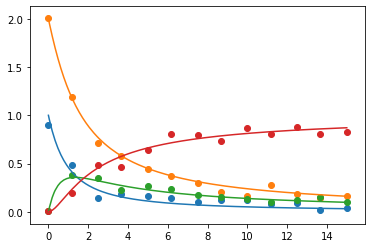

In [26]:
expt = 'Exp3'
fig, ax = plt.subplots()
for x in ['A', 'B', 'C', 'D']:
    ax.scatter(results_pest[expt].C.index, results_pest[expt].C[x])
    ax.plot(results_pest[expt].Z.index, results_pest[expt].Z[x])